This notebook can be used to load raw ultraleap data, 
save cleaned dataframes for each block, 
and generate dataframes of distances for further feature extraction

Import public packages and functions

In [1171]:
import os
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from itertools import compress
import seaborn as sn

import openpyxl
from datetime import datetime
import math
import statistics as stat
import json

In [1172]:
def get_repo_path_in_notebook():
    """
    Finds path of repo from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()
    repo_name = 'ultraleap_analysis'

    while path[-len(repo_name):] != 'ultraleap_analysis':

        path = os.path.dirname(path)

    return path


In [1173]:
repo_path = get_repo_path_in_notebook()
code_path = os.path.join(repo_path, 'code')
os.chdir(code_path)

Import own functions

In [1174]:
import import_data.import_and_convert_data as import_dat
import import_data.find_paths as find_paths
import import_data.preprocessing_meta_info as meta_info
import sig_processing.segment_tasks as seg_tasks
import movement_calc.helpfunctions as hp
import feature_extraction.get_features as get_feat
import feature_extraction.get_features as get_files
import feature_extraction.get_files as get_files
import model_prediction.func_factory as ff

In [1175]:
importlib.reload(ff)

<module 'model_prediction.func_factory' from '/Users/arianm/Documents/GitHub/ultraleap_analysis/code/model_prediction/func_factory.py'>

### 1. Loading Features (X) and scores (y)

Load features from csv and scores/ lables from table

In [1176]:
def loading_features_and_scores(task= str):

    task = task.lower()

    feat_df_path = os.path.join(repo_path, 'data', 'features', 'dataframes', 'patientdata')

    if task == 'ft':
        df = pd.read_csv(os.path.join(feat_df_path, 'ft_block_features.csv'), index_col=0)
    elif task == 'oc':
        df = pd.read_csv(os.path.join(feat_df_path, 'oc_block_features.csv'), index_col=0)

    X_df, y = X_df, y = ff.load_labels_and_adjust_feature_df(df)

    y = np.array(y)

    return X_df, y


In [1177]:
X_df, y = loading_features_and_scores('ft')

In [1178]:
## plotting feature boxplots based on score
# X_df.insert(1, 'scores', y)
# X = X_df[:, 1:]
# df0, df1, df2, df3, df4 =split_dataframe_by_scores(X, 'scores')
# dfs = [df0, df1, df2, df3, df4]
# boxplot_by_dataframe(dfs, 'num_events')

### 2. Select which features you want to use 

In [1179]:
X = X_df.iloc[:, 1:]

<AxesSubplot:title={'center':'Correlation matrix for all FT features'}>

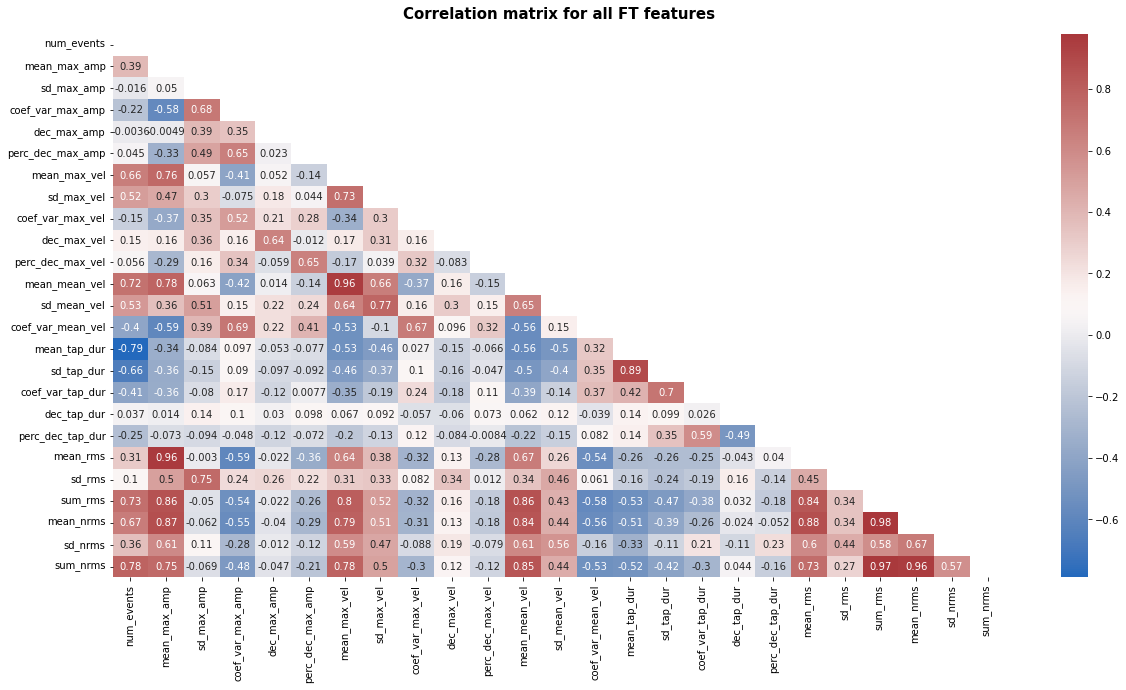

In [1180]:
corr_matrix = X.corr()
matrix = np.triu(corr_matrix)
plt.figure(figsize=(20, 10))
plt.title('Correlation matrix for all FT features',  pad=15, weight = 'bold', fontsize = 15)

sn.heatmap(corr_matrix, annot=True, mask=matrix, cmap="vlag")

In [1181]:
subs = ff.define_groups(X_df, 'sub')
conds = ff.define_groups(X_df, 'cond')

In [1182]:
feat_importance_all = ff.feat_selection_importance(X, y, subs, 20)
feat_importance_all

,feature,importance
0,mean_max_amp,0.035691
1,mean_nrms,0.013993
2,mean_rms,0.004793
3,dec_tap_dur,0.004581
4,dec_max_vel,0.004480
5,dec_max_amp,0.004335
6,perc_dec_tap_dur,0.004185
7,perc_dec_max_vel,0.003882
8,coef_var_max_vel,0.003837
9,mean_mean_vel,0.003369


In [1183]:
# Going through the correlation matrix of all features, comparing importance of two features 
# that have a correlatoin of > abs(0.7), and excluding the one with less importance
del_feat = ['sum_nrms', 'sum_rms', 'mean_tap_dur', 'mean_nrms', 'mean_rms', 'mean_mean_vel', 'mean_max_vel', 
            'sd_max_amp', 'mean_max_vel', 'sd_mean_vel', 'mean_tap_dur', 'sd_tap_dur']

X_new = ff.delete_feat_col(X, del_feat)
feat_importance_filt = ff.feat_selection_importance(X_new, y, subs, 20)
feat_importance_filt

,feature,importance
0,mean_max_amp,0.051768
1,dec_max_vel,0.006419
2,coef_var_tap_dur,0.005650
3,perc_dec_max_vel,0.005616
4,dec_max_amp,0.005510
5,perc_dec_tap_dur,0.005440
6,dec_tap_dur,0.005402
7,num_events,0.005015
8,coef_var_max_vel,0.004880
9,sd_max_vel,0.004826


In [1170]:
r2, feat_names = ff.feat_selection_RFE(X, y, subs, min_features= 15, scoring='r2', step=1, n_jobs=-1)
print(f'Using all features, the RFE with a target of 15 featrues resulted in a r^2 of {r2}')

r2_, feat_names_ = ff.feat_selection_RFE(X_new, y, subs, min_features= 15, scoring='r2', step=1, n_jobs=-1)
print(f'Using the filtered features, the RFE with a target of 15 featrues resulted in a r^2 of {r2_}')

Using all features, the RFE with a target of 15 featrues resulted in a r^2 of 0.884623
Using the filtered features, the RFE with a target of 15 featrues resulted in a r^2 of 0.886426


## Make binary classification problem

In [1184]:
y_binary = y > 1

y = y_binary
y = y.astype(int)

In [1185]:
classifiers = ['linear', 'nonlinear', 'logregression', 'random forest', 'knearest', 'gaussian naive bayes']

In [1186]:
importlib.reload(ff)

<module 'model_prediction.func_factory' from '/Users/arianm/Documents/GitHub/ultraleap_analysis/code/model_prediction/func_factory.py'>

/Users/arianm/anaconda3/envs/ultraleap/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arianm/anaconda3/envs/ultraleap/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arianm/anaconda3/envs/ultraleap/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arianm/anaconda3/envs/ultraleap/lib/python3.9/s

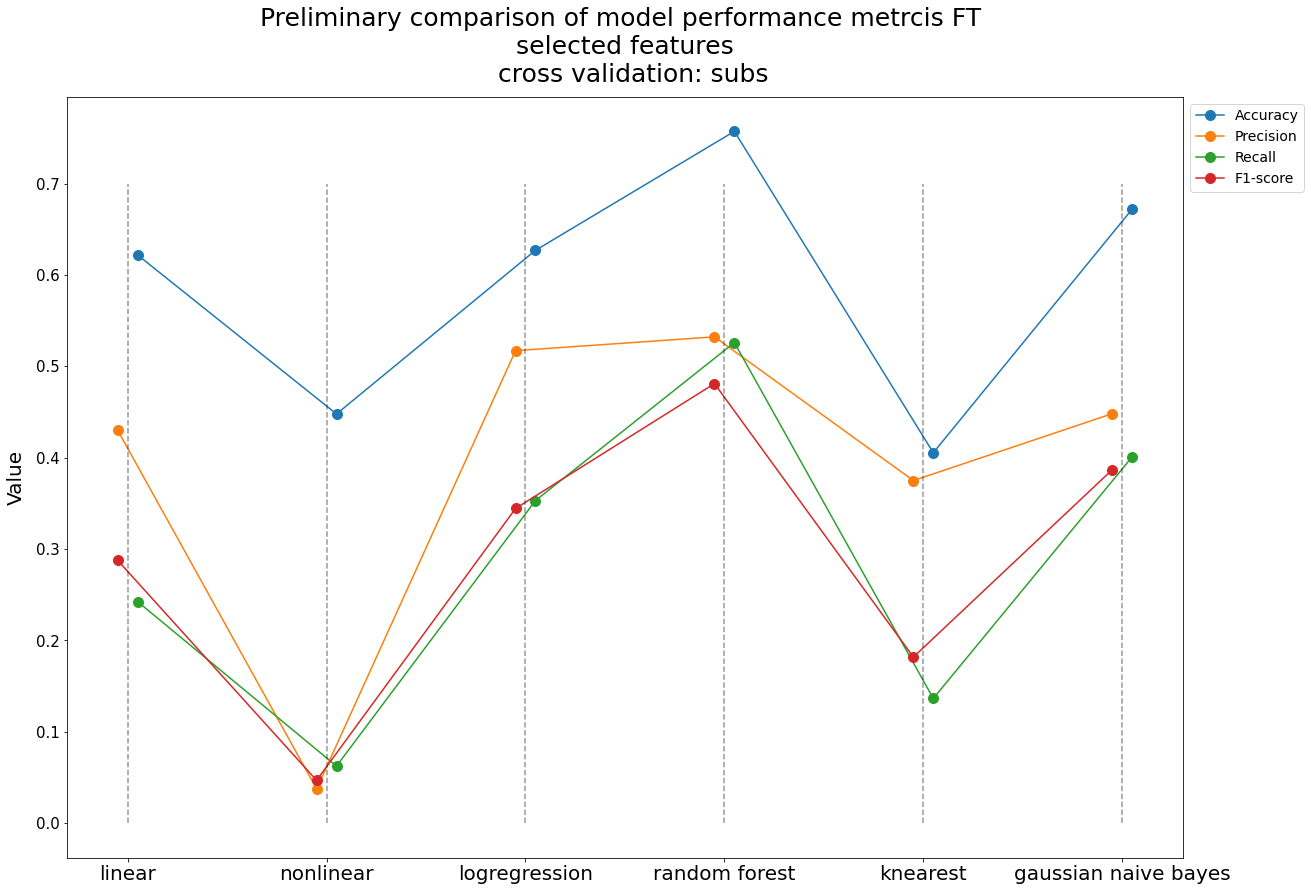

In [1187]:
ff.predictions(X_new, y, classifiers, subs)